# Instalación de las librerías

In [ ]:
!pip install ultralytics
!pip install -U ipywidgets
!pip install supervision

# Carga de librerías

In [ ]:
import os
import random

from ultralytics import YOLO
import cv2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import yaml

from IPython.display import HTML, display
import time

import numpy as np
import supervision as sv

# Descarga dataset

In [ ]:
# Download data from repository and unzip
%cd /content
!wget https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Dataset/trafic_data.zip.001 -O trafic_data.zip.001
!wget https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Dataset/trafic_data.zip.002 -O trafic_data.zip.002
!7z x -y -sdel trafic_data.zip.001
!rm trafic_data.zip.* -f

/content
--2024-04-07 16:10:10--  https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Dataset/trafic_data.zip.001
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104857600 (100M) [application/octet-stream]
Saving to: ‘trafic_data.zip.001’

trafic_data.zip.001 100%[===================>] 100.00M   163MB/s    in 0.6s    

2024-04-07 16:10:11 (163 MB/s) - ‘trafic_data.zip.001’ saved [104857600/104857600]

--2024-04-07 16:10:11--  https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Dataset/trafic_data.zip.002
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.

# Descarga del modelo

In [ ]:
# Download the model and unzip
%cd /content
!wget https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Modelo/yolov8x.zip.001 -O yolov8x.zip.001
!wget https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Modelo/yolov8x.zip.002 -O yolov8x.zip.002
!7z x -y yolov8x.zip.001
!rm yolov8x.zip.* -f

/content
--2024-04-07 16:10:23--  https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Modelo/yolov8x.zip.001
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104857600 (100M) [application/octet-stream]
Saving to: ‘yolov8x.zip.001’

yolov8x.zip.001     100%[===================>] 100.00M   213MB/s    in 0.5s    

2024-04-07 16:10:24 (213 MB/s) - ‘yolov8x.zip.001’ saved [104857600/104857600]

--2024-04-07 16:10:24--  https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Modelo/yolov8x.zip.002
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubuse

# Descarga de las imágenes a atacar

In [ ]:
%mkdir images2attack

In [ ]:
# Download of the images to attack
%cd /content
%mkdir images2attack
%cd /content/images2attack
!wget https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/PFinal-J0nan/Pr%C3%A1cticas/Proyecto%20Final/TestImages/TestImages.zip -O TestImages.zip
!7z x -y TestImages.zip
!rm TestImages.zip -f
%cd /content

# Exploración del dataset

In [ ]:
# Path to files and labels
train_images = "/content/trafic_data/train/images"
train_labels = "/content/trafic_data/train/labels"

valid_images = "/content/trafic_data/train/images"
valid_labels = "/content/trafic_data/train/labels"

In [ ]:
def loadLabels(image_file, image_labels):
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(image_labels, label_file)

    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    return labels

def plotObjectDetections(ax, image, labels):
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.axis('off')

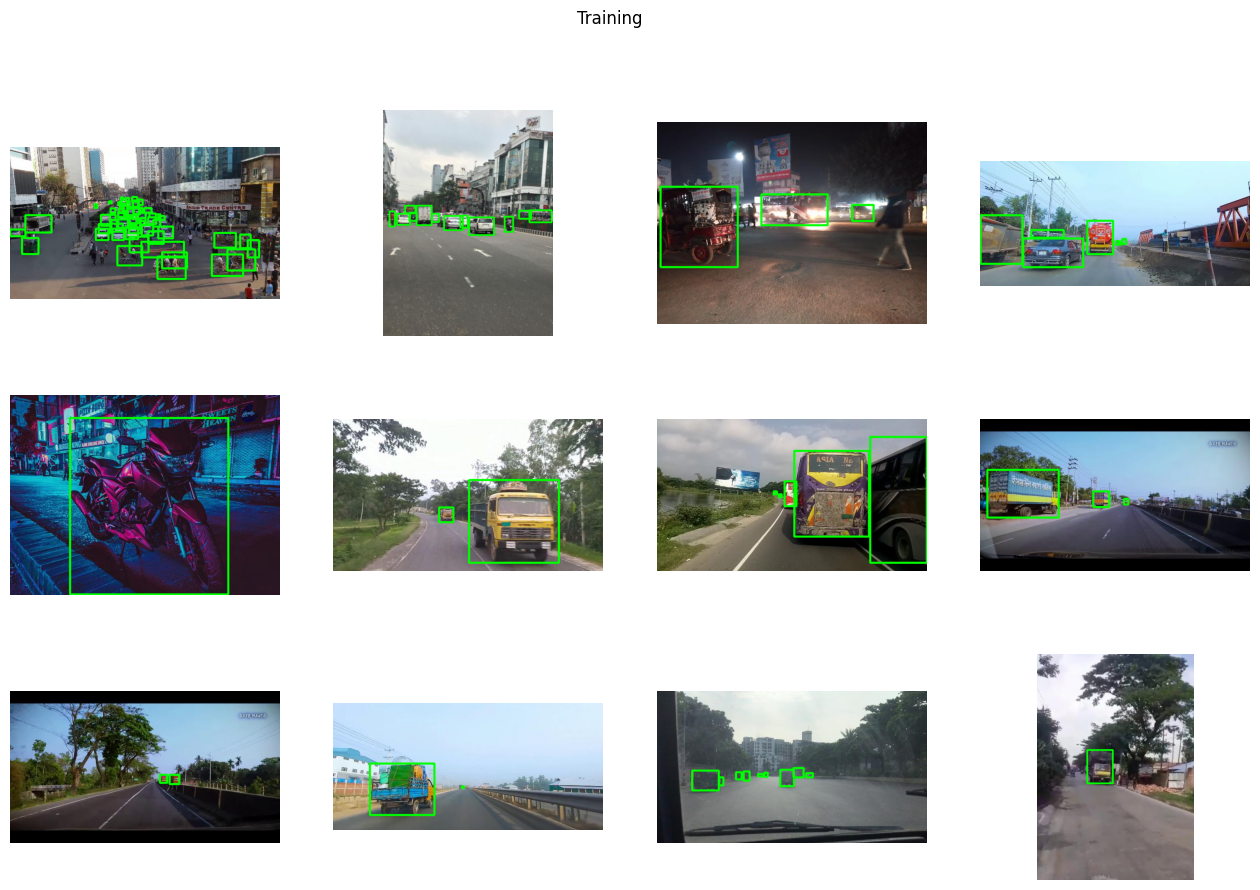

In [ ]:
# List of all the training images
image_files = os.listdir(train_images)

# Choose 12 random image files from the list
random_images = random.sample(image_files, 12)

# Set up the plot
fig, axs = plt.subplots(3, 4, figsize=(16, 10))

for i, image_file in enumerate(random_images):
    row, col = divmod(i, 4)

    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    labels = loadLabels(image_file, train_labels)

    # Plot object detections
    plotObjectDetections(axs[row, col], image, labels)

plt.suptitle("Training")
plt.show()

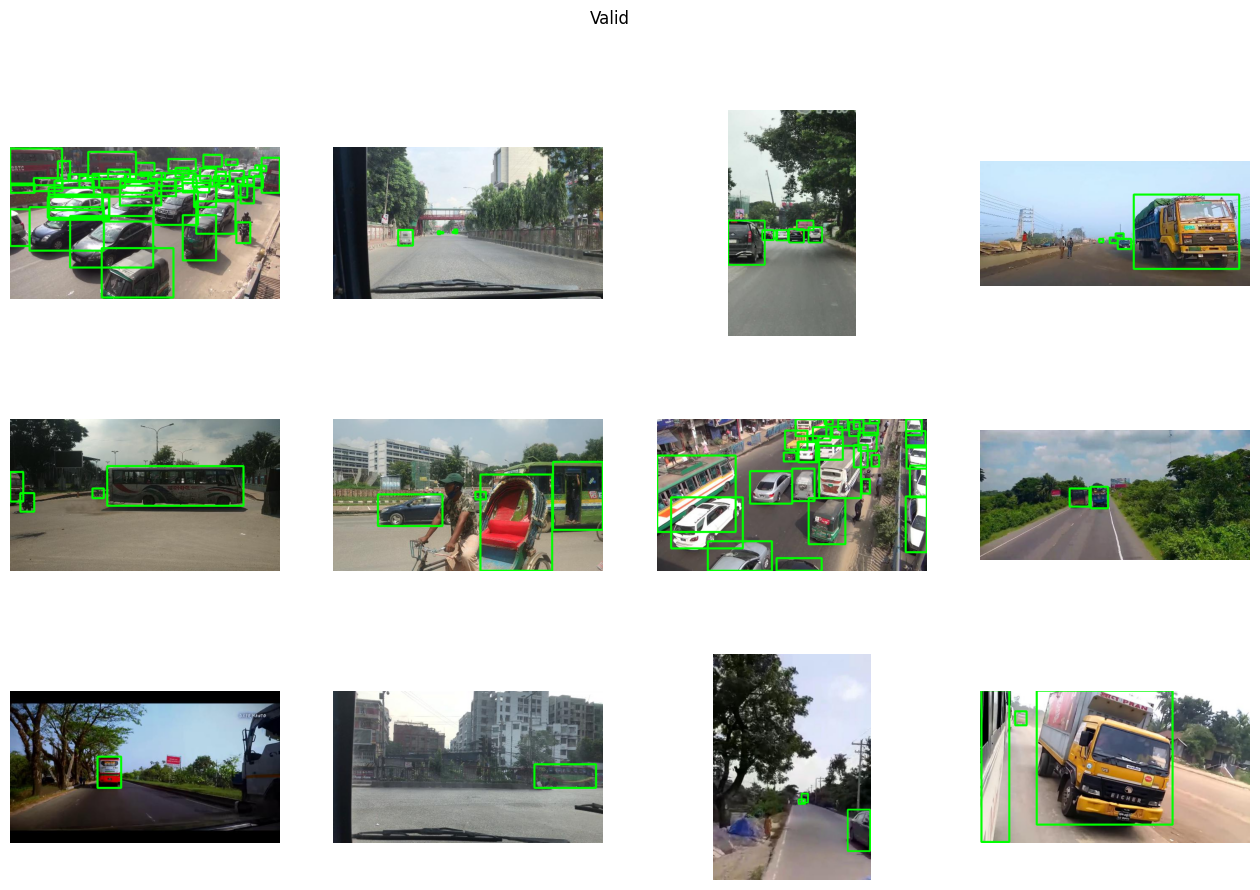

In [ ]:
# List of all the valid images
image_files = os.listdir(valid_images)

# Choose 12 random image files from the list
random_images = random.sample(image_files, 12)

# Set up the plot
fig, axs = plt.subplots(3, 4, figsize=(16, 10))

for i, image_file in enumerate(random_images):
    row, col = divmod(i, 4)

    # Load the image
    image_path = os.path.join(valid_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    labels = loadLabels(image_file, valid_labels)

    # Plot object detections
    plotObjectDetections(axs[row, col], image, labels)

plt.suptitle("Valid")
plt.show()

In [ ]:
# Class names found on the Dataset
with open('/content/trafic_data/data_1.yaml', 'r') as f:
    data_yaml = yaml.load(f, Loader=yaml.FullLoader)

data_yaml["names"]

['ambulance',
 'army vehicle',
 'auto rickshaw',
 'bicycle',
 'bus',
 'car',
 'garbagevan',
 'human hauler',
 'minibus',
 'minivan',
 'motorbike',
 'pickup',
 'policecar',
 'rickshaw',
 'scooter',
 'suv',
 'taxi',
 'three wheelers -CNG-',
 'truck',
 'van',
 'wheelbarrow']

# Comprobación del rendimiento del modelo

## Carga del modelo de Yolo y su entrenamiento

### Modelo de Yolo

In [ ]:
# Cargamos el modelo de yolo
%cd /content
model_yolo = YOLO("yolov8x.pt")

# metrics_yolo = model_yolo.val(data = '/content/trafic_data/data_1.yaml', device='cpu')

### Entrenamiento - Descomentar si se desea entrenar

In [ ]:
# Entrenamiento
'''
model = YOLO('yolov8x.pt')

model.train(data = '/content/trafic_data/data_1.yaml',
            device = '0',
            epochs = 20,
            seed = 42,
            batch = 8,
            workers = 4)

'''

## Carga de modelo entrenado

In [ ]:
# Cargamos el modelo preentrenado
%cd /content
model_trained = YOLO("YOLOv8_Ve.pt")

# metrics_trained = model_trained.val(data = '/content/trafic_data/data_1.yaml', device='cpu')

# Imágenes que se van a atacar

In [ ]:
images_to_hack = ["/content/images2attack/00_truck.jpg",
                  "/content/images2attack/01_furgo.jpg",
                  "/content/images2attack/02_bus_coches.jpg",
                  "/content/images2attack/03_bus_coches.jpg",
                  "/content/images2attack/04_bus_furgoneta.jpg",
                  "/content/images2attack/05_multiple.jpg",
                  ]
for i in range(0,len(images_to_hack),1):
  result_predict_yolo = model_yolo.predict(source = images_to_hack[i], imgsz=(416))
  result_predict_trained = model_trained.predict(source = images_to_hack[i], imgsz=(416))

  image = cv2.imread(images_to_hack[i])
  display(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

  plot = result_predict_yolo[0].plot()
  plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
  display(Image.fromarray(plot))

  plot = result_predict_trained[0].plot()
  plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
  display(Image.fromarray(plot))

# Preparar el ataque

In [ ]:
def perturb_image(coordinates, size, rgb, img):
    for i in range(-size, size, 1):
      for j in range(-size, size, 1):
        img[coordinates[0]+i, coordinates[1]+j] = rgb

    return img

def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Realizamos el ataque

## Busqueda de posición con un pixel

In [ ]:
img = cv2.imread(images_to_hack[3])

predicted = model_trained.predict(source = img, imgsz=(416), conf=0.3)

predicted[0].boxes.cls

In [ ]:
pos = 0
x_width = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][2]-np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][0])
y_width = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][3]-np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][1])

x_ini = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][0]+x_width*0)
x_end = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][2]-x_width*0)
y_ini = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][1]+y_width*0)
y_end = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][3]-y_width*0)


img = cv2.imread(images_to_hack[3])

img_per = perturb_image([y_ini, x_ini], 20, [255,255,255], img)

display(Image.fromarray(cv2.cvtColor(img_per, cv2.COLOR_BGR2RGB)))

In [ ]:
import numpy as np

img = cv2.imread(os.path.join(valid_images, images_to_hack[3]))
solutions = []

predicted = model_trained.predict(source = img, imgsz=(416))
pos = 4
init = 1
max_size = 2
x_width = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][2]-np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][0])
y_width = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][3]-np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][1])

x_ini = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][0]+x_width*0.3)
x_end = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][2]-x_width*0.3)
y_ini = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][1]+y_width*0.3)
y_end = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][3]-y_width*0.3)
total_iterations = (max_size-init)*(x_end-x_ini)*(y_end-y_ini)
print(total_iterations)
out = display(progress(0, total_iterations), display_id=True)

iteration = 0

rgb = [0, 255, 255]
for i in range(init, max_size):
  for x in range (x_ini, x_end, 1):
    for y in range (y_ini, y_end, 1):
      coordinates = [y, x]
      size = i
      img = cv2.imread(os.path.join(valid_images, images_to_hack[3]))
      image_perturbed = perturb_image(coordinates, size, rgb, img)
      predicted = model_trained.predict(source = image_perturbed,imgsz=(416),verbose=False, conf = 0.3)
      unique_elements, counts = np.unique(predicted[0].boxes.cls.to('cpu'), return_counts=True)
      if counts[0] < 2:
        print("cajas:", predicted[0].boxes.cls)
        solutions.append([i,x,y])
        print("unique elements:", unique_elements)
        print("counts:",  counts)

      iteration = iteration + 1
      out.update(progress(iteration, total_iterations))

# plot = result_predict_trained[0].plot()
# plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
# display(Image.fromarray(plot))

## Busqueda de posición con dos pixeles

In [ ]:
img = cv2.imread(images_to_hack[3])

predicted = model_trained.predict(source = img, imgsz=(416), conf=0.4)

predicted[0].boxes.cls

In [ ]:
pos = 0
x_width = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][2]-np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][0])
y_width = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][3]-np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][1])

x_ini = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][0]+x_width*0)
x_end = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][2]-x_width*0)
y_ini = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][1]+y_width*0)
y_end = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][3]-y_width*0)


img = cv2.imread(images_to_hack[3])

img_per = perturb_image([y_ini, x_ini], 20, [255,255,255], img)

display(Image.fromarray(cv2.cvtColor(img_per, cv2.COLOR_BGR2RGB)))

In [ ]:
# DETERMINA EL NÚMERO DE ITERACIONES

index_img_2_hack = 3
max_size = 10
ini_size = 9
pos = 0
margin = 0.3

img = cv2.imread(images_to_hack[index_img_2_hack])
solutions_yolo = []
solutions_trained = []

predicted = model_trained.predict(source = img, imgsz=(416))

x_width = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][2]-np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][0])
y_width = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][3]-np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][1])

x_ini = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][0]+x_width*margin)
x_end = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][2]-x_width*margin)
y_ini = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][1]+y_width*margin)
y_end = int(np.array(predicted[0].boxes.xyxy.to('cpu'))[pos][3]-y_width*margin)

print(ini_size, max_size)
print(x_ini, x_end, x_end-x_ini)
print(y_ini, y_end, y_end-y_ini)

num_iterations = 0
for i in range(ini_size, max_size):
    for x in range(x_ini, x_end, i):
        for y in range(y_ini, y_end, i):
          for x2 in range(x_ini, x_end, i):
            for y2 in range(y_ini, y_end, i):
              num_iterations += 1


print(num_iterations)

In [ ]:
total_iterations = num_iterations

print(total_iterations)

out = display(progress(0, total_iterations), display_id=True)

iteration = 0

rgb = [255, 255, 255]
rgb2 = [255, 255, 0]
for i in range(ini_size, max_size):
  for x in range (x_ini, x_end, i):
    for y in range (y_ini, y_end, i):
      coordinates = [y, x]
      size = i

      for x2 in range (x_ini, x_end, i):
        for y2 in range (y_ini, y_end, i):
          coordinates2 = [y2, x2]

          img = cv2.imread(images_to_hack[index_img_2_hack])
          image_perturbed = perturb_image(coordinates, size, rgb, img)
          image_perturbed2 = perturb_image(coordinates2, size, rgb2, image_perturbed)

          # Trained
          if len(solutions_trained) < 30:
            predicted_trained = model_trained.predict(source = image_perturbed2,imgsz=(416),verbose=False, conf=0.4)
            detections_trained = sv.Detections.from_ultralytics(predicted_trained[0])
            detections_trained_bus = detections_trained[detections_trained.class_id == list(predicted_trained[0].names.values()).index('bus')]
          if len(detections_trained_bus) < 2:
            solutions_trained.append([x,y,i,x2,y2])
            print("Found trained ", (predicted_trained[0].boxes.cls.tolist()), len(solutions_trained), size)
            if len(solutions_trained) < 5:
              plot = predicted_trained[0].plot()
              plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
              display(Image.fromarray(plot))

          # Yolo
          # if len(solutions_yolo) < 30:
          #   predicted_yolo = model_yolo.predict(source = image_perturbed2,imgsz=(416),verbose=False, conf=0.25)
          #   detections_yolo = sv.Detections.from_ultralytics(predicted_yolo[0])
          #   detections_yolo_bus = detections_yolo[detections_yolo.class_id == list(predicted_yolo[0].names.values()).index('car')]
          #   if len(detections_yolo_bus) < 9:
          #     solutions_yolo.append([x,y,i,x2,y2])
          #     print("Found yolo ", (predicted_yolo[0].boxes.cls.tolist()), len(solutions_yolo))
          #     if len(solutions_yolo) < 3:
          #       plot = predicted_yolo[0].plot()
          #       plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
          #       display(Image.fromarray(plot))
          iteration = iteration + 1
          out.update(progress(iteration, total_iterations))

## Ataques con posiciones conocidas

### Imagen 0

In [ ]:
# Show results

img = cv2.imread(images_to_hack[0])
coordinates = [358, 109]
size = 1
rgb = [0, 255, 255]
conf = 0.3

perturb_image(coordinates, size, rgb, img)

# coordinates = [501, 188]
# size = 5
# rgb = [255, 255, 0]

# perturb_image(coordinates, size, rgb, img)

# coordinates = [466, 173]
# size = 5
# rgb = [255, 255, 255]

# perturb_image(coordinates, size, rgb, img)


display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

# result_predict_yolo = model_yolo.predict(source = img, imgsz=(416), conf=conf)
# plot = result_predict_yolo[0].plot()
# plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
# display(Image.fromarray(plot))

result_predict_trained = model_trained.predict(source = img, imgsz=(416), conf=conf)
plot = result_predict_trained[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

### Imagen 2

In [ ]:
# Show results

img = cv2.imread(images_to_hack[2])
coordinates = [380, 680]
size = 5
rgb = [255, 255, 0]
conf = 0.3

perturb_image(coordinates, size, rgb, img)

# coordinates = [501, 188]
# size = 5
# rgb = [255, 255, 0]

# perturb_image(coordinates, size, rgb, img)

# coordinates = [466, 173]
# size = 5
# rgb = [255, 255, 255]

# perturb_image(coordinates, size, rgb, img)


display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

# result_predict_yolo = model_yolo.predict(source = img, imgsz=(416), conf=conf)
# plot = result_predict_yolo[0].plot()
# plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
# display(Image.fromarray(plot))

result_predict_trained = model_trained.predict(source = img, imgsz=(416), conf=conf)
plot = result_predict_trained[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

### Imagen 1

In [ ]:
# Show results

img = cv2.imread(images_to_hack[1])
coordinates = [543, 832]
size = 7
rgb = [255, 255, 0]
conf = 0.3

perturb_image(coordinates, size, rgb, img)

# coordinates = [501, 188]
# size = 5
# rgb = [255, 255, 0]

# perturb_image(coordinates, size, rgb, img)

# coordinates = [466, 173]
# size = 5
# rgb = [255, 255, 255]

# perturb_image(coordinates, size, rgb, img)


display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

# result_predict_yolo = model_yolo.predict(source = img, imgsz=(416), conf=conf)
# plot = result_predict_yolo[0].plot()
# plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
# display(Image.fromarray(plot))

result_predict_trained = model_trained.predict(source = img, imgsz=(416), conf=conf)
plot = result_predict_trained[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

### Imagen 3

In [ ]:
# Show results - First bus

img = cv2.imread(images_to_hack[3])
coordinates = [466, 173]
size = 5
rgb = [255, 255, 255]
conf = 0.4

perturb_image(coordinates, size, rgb, img)

coordinates = [501, 188]
size = 5
rgb = [255, 255, 0]

perturb_image(coordinates, size, rgb, img)

# coordinates = [466, 173]
# size = 5
# rgb = [255, 255, 255]

# perturb_image(coordinates, size, rgb, img)


display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

# result_predict_yolo = model_yolo.predict(source = img, imgsz=(416), conf=conf)
# plot = result_predict_yolo[0].plot()
# plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
# display(Image.fromarray(plot))

result_predict_trained = model_trained.predict(source = img, imgsz=(416), conf=conf)
plot = result_predict_trained[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

In [ ]:
# Show results - First & second bus

img = cv2.imread(images_to_hack[3])
coordinates = [466, 173]
size = 5
rgb = [255, 255, 255]
conf = 0.4

perturb_image(coordinates, size, rgb, img)

coordinates = [501, 188]
size = 5
rgb = [255, 255, 0]

perturb_image(coordinates, size, rgb, img)

coordinates = [441, 328]
size = 1
rgb = [0, 255, 255]

perturb_image(coordinates, size, rgb, img)


display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

# result_predict_yolo = model_yolo.predict(source = img, imgsz=(416), conf=conf)
# plot = result_predict_yolo[0].plot()
# plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
# display(Image.fromarray(plot))

result_predict_trained = model_trained.predict(source = img, imgsz=(416), conf=conf)
plot = result_predict_trained[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

# Aplicaciones en la vida real